## Import Libraries

In [237]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import plotly.express as px
import warnings




## Import data : the scraper was run multiple time hence multiple csv files for apartment listing

In [238]:
df3 = pd.read_csv('data_final3.csv', sep=';')

df6 = pd.read_csv('data_final6.csv', sep=';')
df7 = pd.read_csv('data_final7.csv', sep=';')
df9 = pd.read_csv('data_final9.csv', sep=';')

# # Concatenate all DataFrames into a single DataFrame
apartment_data = pd.concat([ df3, df6, df7,df9], ignore_index=True)
population = pd.read_csv('registered_people_n_streets.csv')



In [240]:
# Lithuanian to English column mapping
column_mapping = {
    "GIMIMO_METAI": "BIRTH_YEAR",
    "GIMIMO_VALSTYBE": "BIRTH_COUNTRY",
    "LYTIS": "GENDER",
    "SEIMOS_PADETIS": "MARITAL_STATUS",
    "KIEK_TURI_VAIKU": "NUMBER_OF_CHILDREN",
    "SENIUNIJA": "neighbourhood",
    "GATVE": "STREET",
    "SENIUNNR": "neighbourhood_ID",
    "TER_REJ_KODAS": "REGION_CODE",
    "GATV_K": "STREET_CODE",
    "GAT_ID": "STREET_ID"
}


population = population .rename(columns=column_mapping)

population['MARITAL_STATUS'].fillna('S', inplace=True)
# Group by STREET and calculate summary statistics
street_summary = population.groupby(["STREET","neighbourhood"]).agg(
    AVG_BIRTH_YEAR=("BIRTH_YEAR", "mean"),              # Average birth year
    TOTAL_CHILDREN=("NUMBER_OF_CHILDREN", "sum"),       # Total children per street
    MARITAL_STATUS_COUNTS=("MARITAL_STATUS", lambda x: x.value_counts().to_dict()),  # Count of each marital status
    TOTAL_PEOPLE=("BIRTH_YEAR", "count")                # Total count of people per street
    
).reset_index()

expanded_rows = []
for d in street_summary['MARITAL_STATUS_COUNTS']:
    # Create a dict with keys 'I', 'N', 'V', defaulting to 0
    expanded_row = {'I': 0, 'N': 0, 'V': 0, 'S':0}
    if isinstance(d, dict):
    # Update with values from the dictionary
        expanded_row.update(d)
        expanded_rows.append(expanded_row)

# Create a DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

street_summary = pd.concat([street_summary, expanded_df], axis=1)

martial_status_map = { 'V': 'TOTAL_MARRIED',
'I': 'TOTAL_DIVORCED',
'N': 'TOTAL_WIDOWED',
'S': 'TOTAL_SINGLE'}
street_summary = street_summary.rename(columns=martial_status_map)
street_summary.drop(['MARITAL_STATUS_COUNTS'], axis=1, inplace=True)

In [241]:
#Remove duplicates
data = apartment_data.drop_duplicates()

# Data cleaning and standardisation

In [ ]:
data['Price'] = data['price'].str.extract(r'(\d[\d\s]*€)')[0]
data['Price'] = data['Price'].str.replace(r'[ €]', '', regex=True).astype(int)
data['Percent_Decrease'] = data['price'].str.extract(r'(\d{1,2},\d%|\d{1,2}%|\d,\d%)')

In [ ]:
years = data['Build year'].str.extractall(r'(\d{4})')

# Assign build and renovation years to new columns
data['build_year'] = years[0].groupby(level=0).first()
data['renovation_year'] = years[0].groupby(level=0).nth(1)
data['build_year'] = data['build_year'].astype("int")

# # Convert to integer type
# data['build_year'] = data['build_year'].astype(int)
data['renovation_year'] = pd.to_numeric(data['renovation_year'], errors='coerce')
data['Area'] = data['Area'].str.replace(' m²', '').str.replace(',', '.').astype(float)


### Standardise units 


In [248]:
def clean_value(value):
    if pd.isna(value):  # Check for NaN values
        return np.nanß
    if 'km' in value:
        # Convert km to m
        return float(value.replace(' km', '').replace(',', '.')) * 1_000
    else:
        # Remove " m²", replace commas with dots, and convert to float
        return float(value.replace(' m', '').replace(',', '.'))



In [ ]:
data['Nearest shop'] = data['Nearest shop'].apply(clean_value)
data['Nearest educational institution'] = data['Nearest educational institution'].apply(clean_value)
data['Nearest kindergarten'] = data['Nearest kindergarten'].apply(clean_value)
data['Public transport stop'] = data['Public transport stop'].apply(clean_value)

In [250]:
# Calculate the percentage of missing values for each column
missing_percentage = data.isnull().mean() * 100

# Display the results
missing_percentage = missing_percentage[missing_percentage > 0]  # Only show columns with missing values
print(missing_percentage)


House No.                           31.543418
Flat No.                            90.549248
Building Energy Efficiency Class    79.257441
Description                         29.426204
Additional premises                 34.151580
Additional Equipment                34.550476
Security                            33.537895
Nearest kindergarten                 0.030684
Nearest educational institution      0.030684
Nearest shop                         0.030684
Public transport stop                0.276158
crime                                0.030684
Object                              99.539736
Unique item number (RC number)      99.693157
Percent_Decrease                    75.176434
renovation_year                     91.500460
dtype: float64


In [ ]:
# drop not needed columns
data.drop(['Unique item number (RC number)','Object','Description', 'Build year','House No.','Flat No.', 'price'], axis=1, inplace=True)

In [ ]:
data['is_renovated'] = data['renovation_year'].apply(lambda x: 1 if pd.notnull(x) else 0)
data['is_price_decreased'] = data['Percent_Decrease'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [253]:
# Get the top 10 and last 10 neighborhoods by listing count
top_10_neighbourhoods = data['neighbourhood'].value_counts().nlargest(10)
bottom_10_neighbourhoods = data['neighbourhood'].value_counts().nsmallest(10)
overall_counts = data['neighbourhood'].value_counts()

In [254]:
# Concatenate the top and bottom neighborhoods
combined_neighbourhoods = pd.concat([top_10_neighbourhoods, bottom_10_neighbourhoods])


## Removing outskirts

In [255]:
valid_neighbourhoods = overall_counts[overall_counts >= 19].index

filtered_data = data[(data['neighbourhood'].isin(valid_neighbourhoods))& (data['neighbourhood']!='Grigiškės')]
filtered_data_counts =filtered_data['neighbourhood'].value_counts()

## Exploratory data analysis

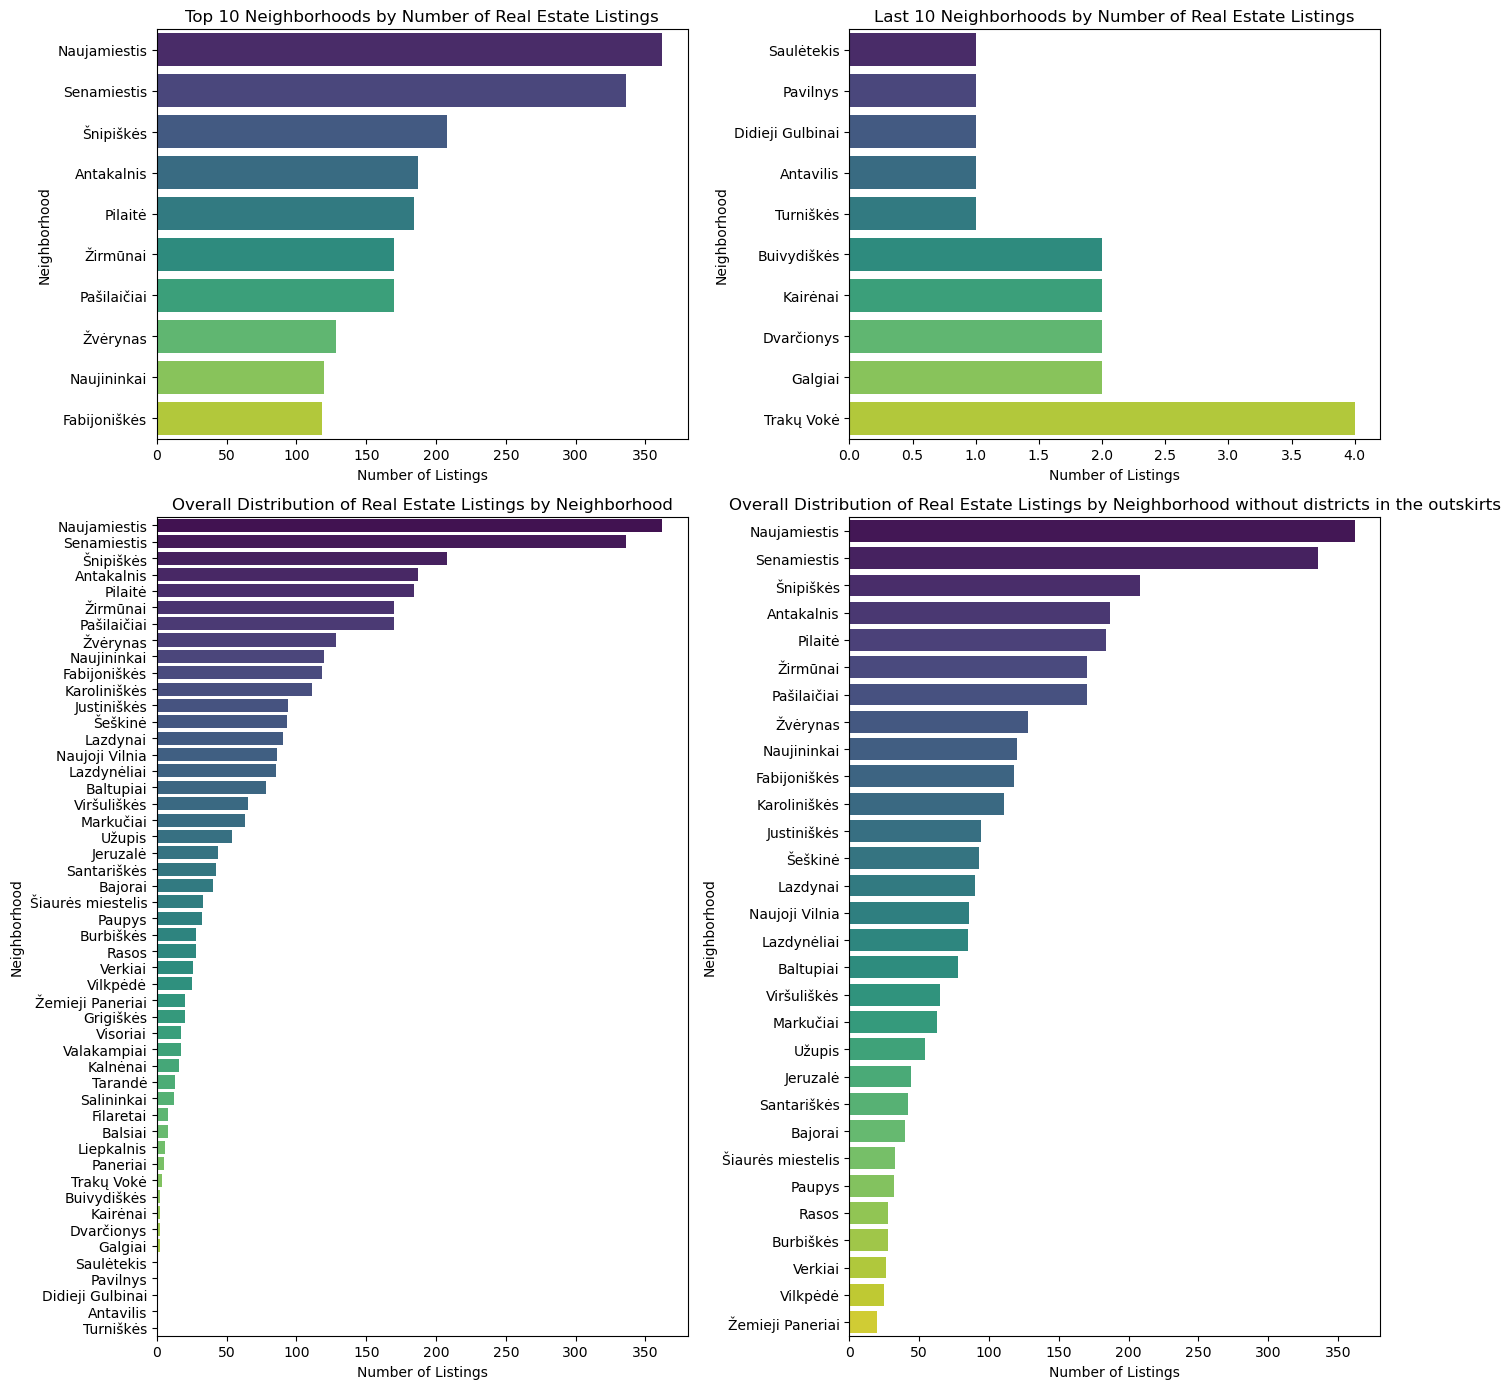

In [257]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), gridspec_kw={'height_ratios': [1, 2]})

# Top 10 Neighborhoods Plot 
sns.barplot(x=top_10_neighbourhoods.values, y=top_10_neighbourhoods.index, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Top 10 Neighborhoods by Number of Real Estate Listings')
axes[0, 0].set_xlabel('Number of Listings')
axes[0, 0].set_ylabel('Neighborhood')

# Last 10 Neighborhoods Plot 
sns.barplot(x=bottom_10_neighbourhoods.values, y=bottom_10_neighbourhoods.index, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Last 10 Neighborhoods by Number of Real Estate Listings')
axes[0, 1].set_xlabel('Number of Listings')
axes[0, 1].set_ylabel('Neighborhood')

# Overall Distribution Plot 
sns.barplot(x=overall_counts.values, y=overall_counts.index, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title('Overall Distribution of Real Estate Listings by Neighborhood')
axes[1, 0].set_xlabel('Number of Listings')
axes[1, 0].set_ylabel('Neighborhood')


# Overall Distribution Plot 
sns.barplot(x=filtered_data_counts.values, y=filtered_data_counts.index, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Overall Distribution of Real Estate Listings by Neighborhood without districts in the outskirts')
axes[1, 1].set_xlabel('Number of Listings')
axes[1, 1].set_ylabel('Neighborhood')
# Hide the empty subplot 
# axes[1, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


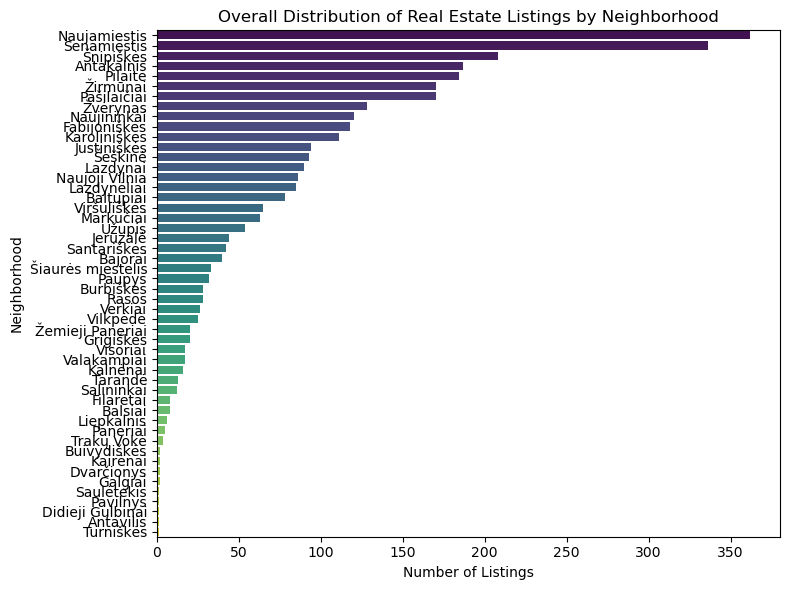

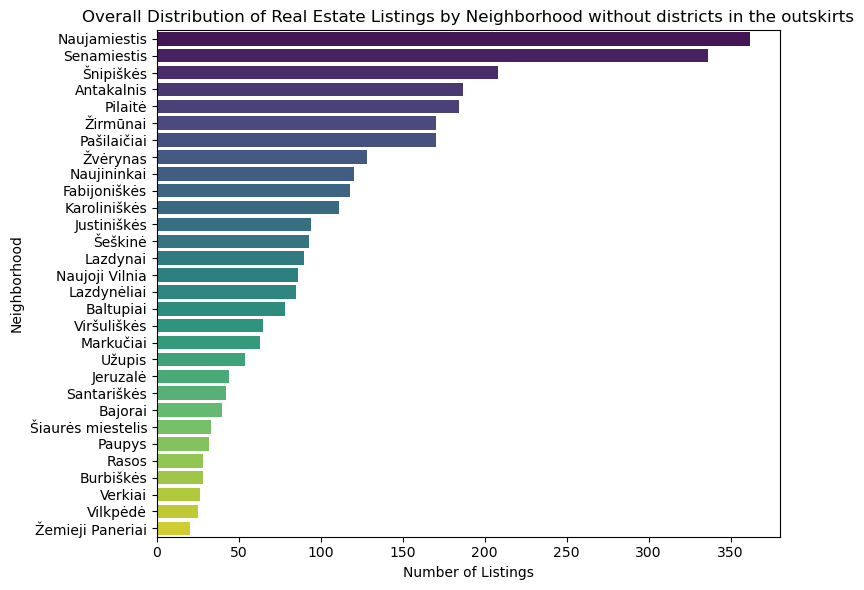

In [258]:


# Overall Distribution Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=overall_counts.values, y=overall_counts.index, palette="viridis")
plt.title('Overall Distribution of Real Estate Listings by Neighborhood')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig("overall_distribution.png", dpi=300)  # Save as separate file
plt.show()

# Filtered Distribution Plot (without outskirts)
plt.figure(figsize=(8, 6))
sns.barplot(x=filtered_data_counts.values, y=filtered_data_counts.index, palette="viridis")
plt.title('Overall Distribution of Real Estate Listings by Neighborhood without districts in the outskirts')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig("filtered_distribution.png", dpi=300)  # Save as separate file
plt.show()


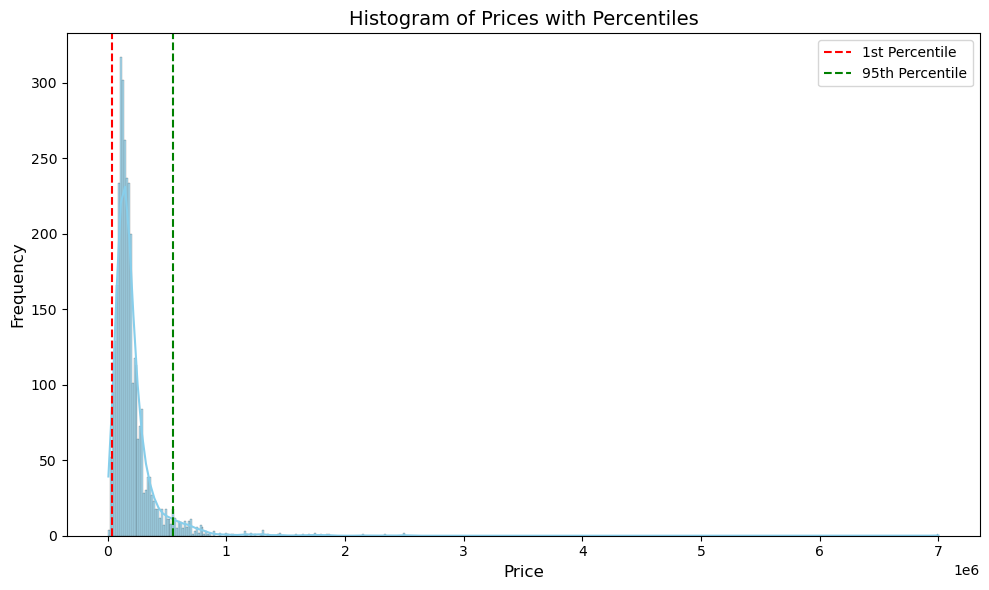

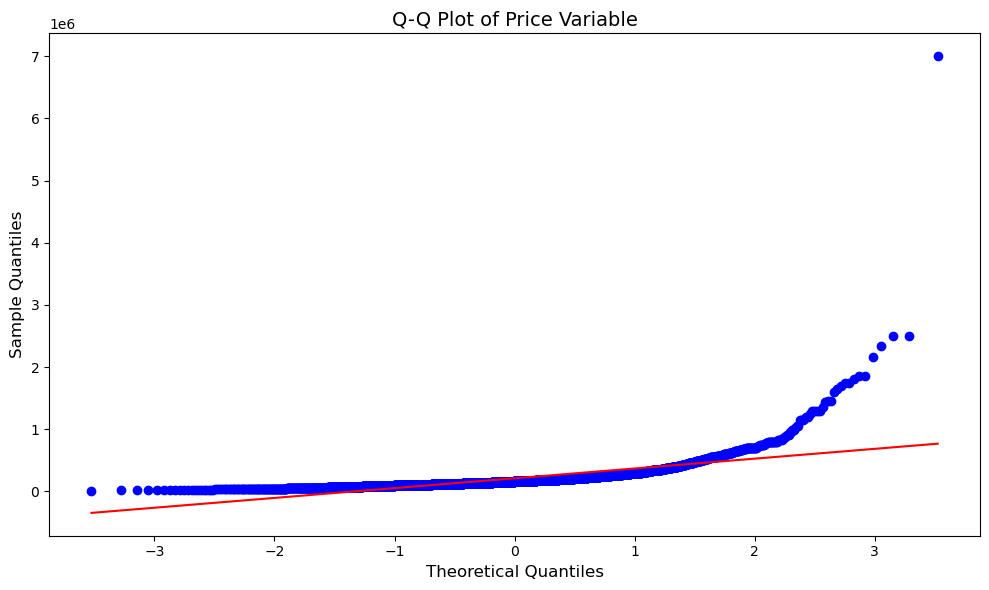

In [259]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate percentiles and bounds
lower_bound = data['Price'].quantile(0.01)
upper_bound = data['Price'].quantile(0.95)
percentiles = data['Price'].quantile([0.01, 0.95])

# Histogram with percentiles
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True, color='skyblue', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='1st Percentile')
plt.axvline(upper_bound, color='green', linestyle='--', label='95th Percentile')
plt.title('Histogram of Prices with Percentiles', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("histogram_prices_percentiles.png")  # Save the figure for LaTeX
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(data['Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price Variable', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.tight_layout()
plt.savefig("qq_plot_prices.png")  # Save the figure for LaTeX
plt.show()


## Outlier Removal

In [261]:
# Define lower and upper bounds based on percentiles
lower_bound =filtered_data['Price'].quantile(0.01)
upper_bound = filtered_data['Price'].quantile(0.95)

# Filter the data to exclude outliers
filtered_data_outliers = filtered_data[(filtered_data['Price'] >= lower_bound) & (filtered_data['Price'] <= upper_bound)].reset_index(drop=True)

# Display or further process the filtered dataset
filtered_data_outliers


,city,neighbourhood,street,Area,Number of rooms,Floor,No. of floors,Building type,Heating system,Equipment,...,Nearest educational institution,Nearest shop,Public transport stop,crime,Price,Percent_Decrease,build_year,renovation_year,is_renovated,is_price_decreased
0,Vilnius,Santariškės,Dangeručio g.,65.01,3,3,4,Brick,"Electric, aerothermal",Fully equipped,...,3400.0,220.0,590.0,0,199000,NaN,2022,NaN,0,0
1,Vilnius,Antakalnis,Antakalnio g.,83.30,3,1,3,Brick,Central,Partially equipped,...,180.0,590.0,20.0,5,366520,NaN,2025,NaN,0,0
2,Vilnius,Lazdynėliai,Lietaus g.,30.65,1,4,4,Brick,Central thermostat,Partially equipped,...,1500.0,210.0,160.0,0,100400,NaN,2023,NaN,0,0
3,Vilnius,Bajorai,Bajorų kel.,43.05,2,3,5,Brick,Central thermostat,Partially equipped,...,1400.0,230.0,160.0,0,117000,NaN,2023,NaN,0,0
4,Vilnius,Lazdynėliai,Lazdynėlių g.,63.02,4,2,4,Brick,Central thermostat,Partially equipped,...,1400.0,220.0,170.0,0,176000,"3,3%",2022,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,Vilnius,Naujamiestis,Žemaitės g.,50.15,2,3,5,Brick,Central,Fully equipped,...,240.0,160.0,110.0,"53,66 €/month\n~ 1,07 €/m²",156000,NaN,1966,NaN,0,0
2929,Vilnius,Antakalnis,M. K. Oginskio g.,40.79,2,2,3,Brick,Central thermostat,Fully equipped,...,180.0,230.0,140.0,6,115000,NaN,1961,2017.0,1,0
2930,Vilnius,Vilkpėdė,Vandentiekio g.,62.68,3,1,4,Brick,"Geothermal, sun energy",Partially equipped,...,180.0,440.0,240.0,13,209351,"1,8%",2025,NaN,0,1
2931,Vilnius,Šnipiškės,Giedraičių g.,36.54,2,2,2,Log house,"Electric, solid fuel",Fully equipped,...,560.0,320.0,240.0,20,45000,NaN,1940,NaN,0,0


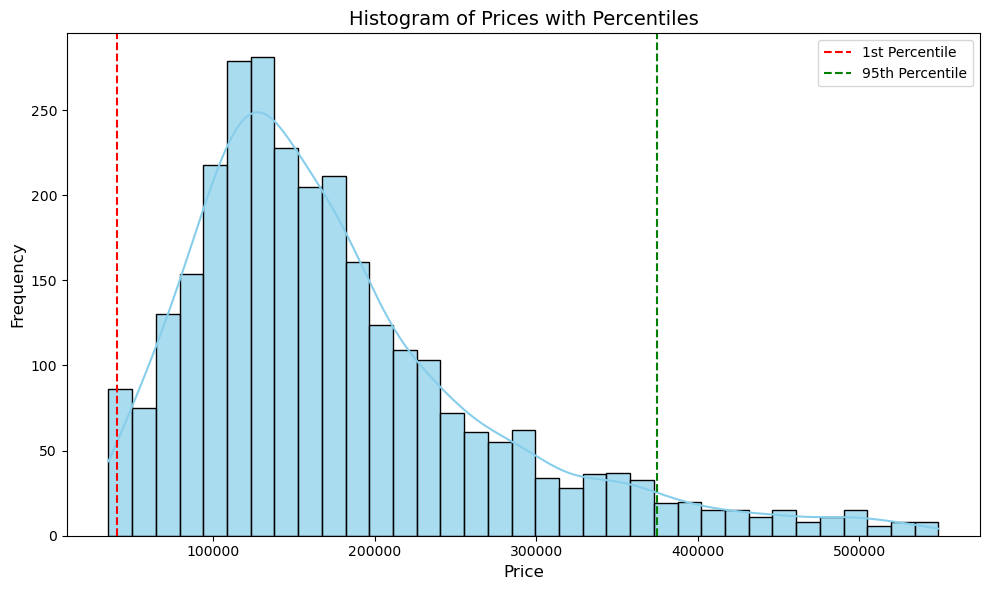

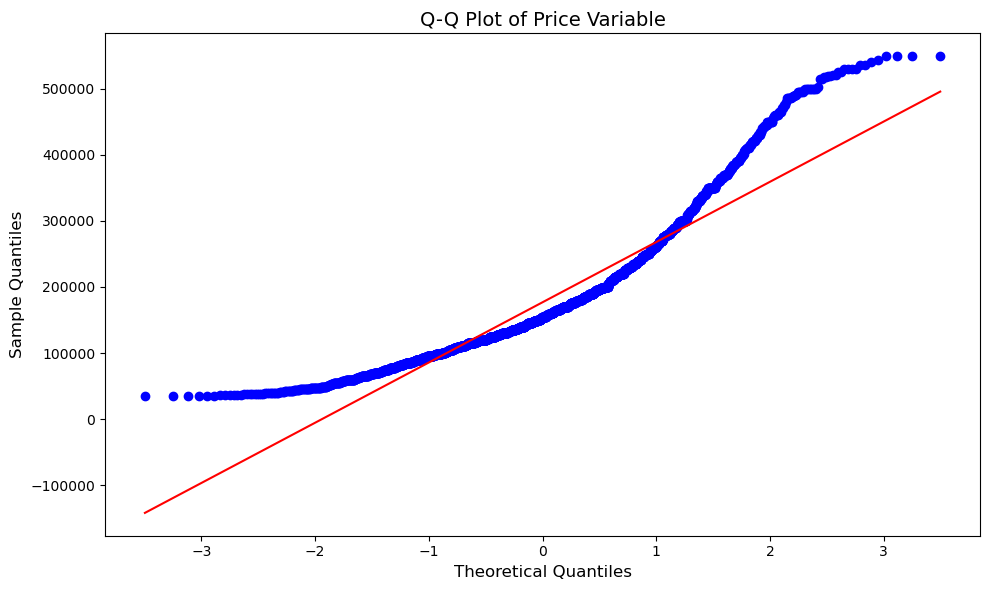

In [262]:


# Calculate percentiles and bounds
lower_bound = filtered_data_outliers['Price'].quantile(0.01)
upper_bound = filtered_data_outliers['Price'].quantile(0.95)
percentiles = filtered_data_outliers['Price'].quantile([0.01, 0.95])

# Histogram with percentiles
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data_outliers['Price'], kde=True, color='skyblue', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='1st Percentile')
plt.axvline(upper_bound, color='green', linestyle='--', label='95th Percentile')
plt.title('Histogram of Prices with Percentiles', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("histogram_prices_percentiles.png")  # Save the figure for LaTeX
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(filtered_data_outliers['Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Price Variable', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.tight_layout()
plt.savefig("qq_plot_prices_after_outliers_removal.png")  # Save the figure for LaTeX
plt.show()


In [263]:
full_data = filtered_data_outliers.merge(street_summary, left_on =['street','neighbourhood'], right_on=['STREET','neighbourhood'], how='left')

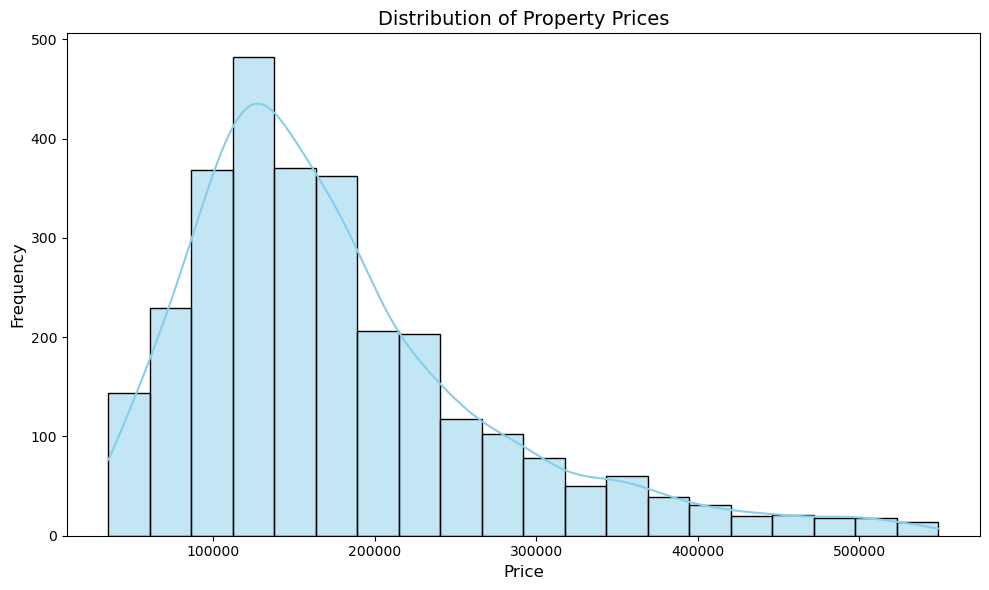

In [264]:
plt.figure(figsize=(10, 6))
sns.histplot(full_data['Price'], kde=True, bins=20, color='skyblue', edgecolor='black')

# Adding labels and title
plt.title('Distribution of Property Prices', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Distribution of apartmnents by neighbourhood

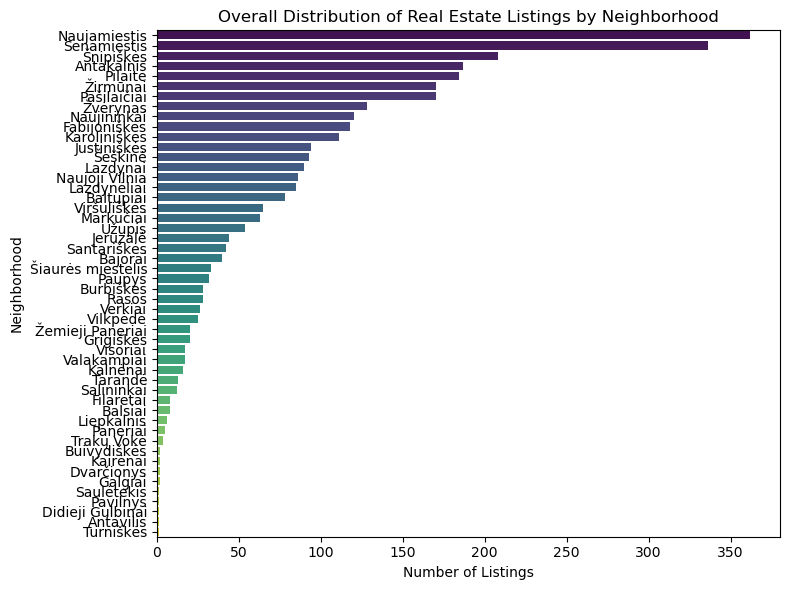

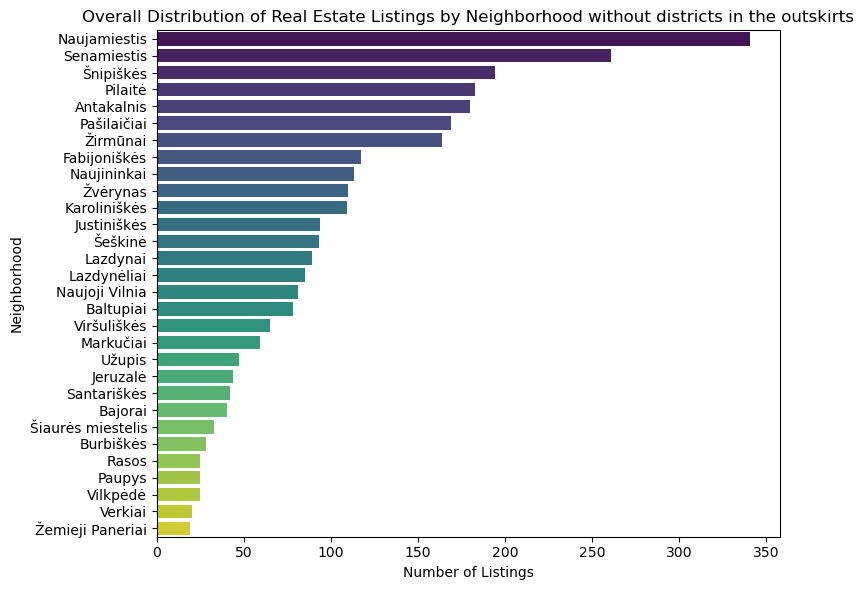

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns

valid_neighbourhoods = overall_counts[overall_counts >= 19].index


full_data_counts =full_data['neighbourhood'].value_counts()

# Overall Distribution Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=overall_counts.values, y=overall_counts.index, palette="viridis")
plt.title('Overall Distribution of Real Estate Listings by Neighborhood')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig("overall_distribution.png", dpi=300)  # Save as separate file
plt.show()

# Filtered Distribution Plot (without outskirts)
plt.figure(figsize=(8, 6))
sns.barplot(x=full_data_counts.values, y=full_data_counts.index, palette="viridis")
plt.title('Overall Distribution of Real Estate Listings by Neighborhood without districts in the outskirts')
plt.xlabel('Number of Listings')
plt.ylabel('Neighborhood')
plt.tight_layout()
plt.savefig("filtered_distribution.png", dpi=300)  # Save as separate file
plt.show()


## Distribution of apartmnents prices  vs year constructed

In [266]:

# Create the scatter plot with a regression line
fig = px.scatter(
    full_data, 
    x='build_year', 
    y='Price', 
    color='build_year',  # Color points by 'Build year'
    trendline='ols',     # Add a trendline
    color_continuous_scale='Viridis',  # Choose a color scale
    labels={'Build year': 'Build year', 'Price': 'Price'},
    title='Year Constructed vs. Property Price'
)

# Update layout for better appearance
fig.update_layout(
    title_font_size=16,
    xaxis_title="Build year",
    yaxis_title="Price",
    plot_bgcolor="rgba(0, 0, 0, 0)",  # Transparent background
    xaxis=dict(
        tickmode='linear',  # Linear ticks for even spacing
        tick0=full_data['build_year'].min(),  # Starting point
        dtick=10            # Interval of 10 years
    )
)

# Show the plot
fig.show()

### Apartment Prices VS No of floors

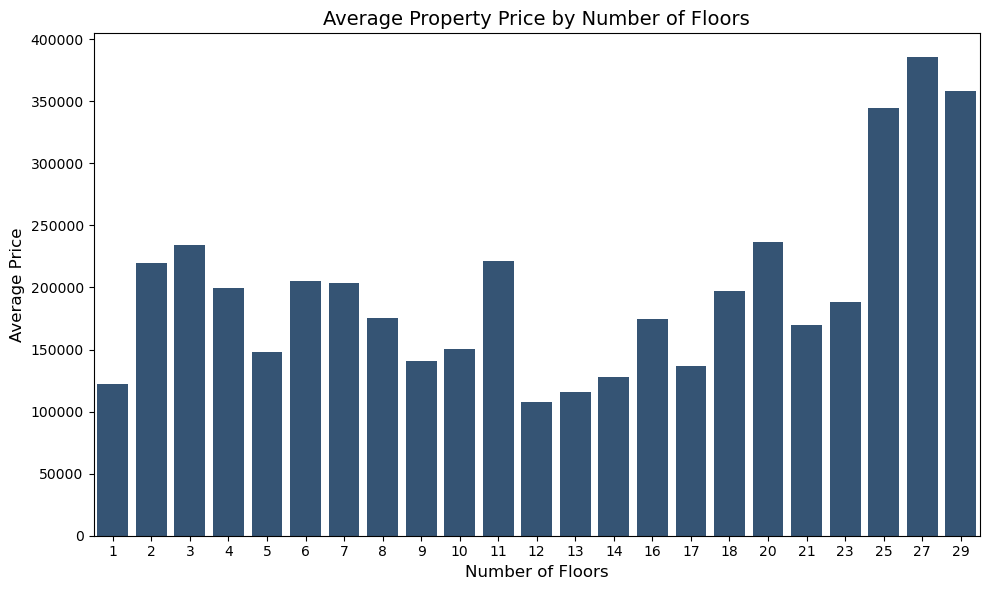

In [267]:


# Calculate the average price by number of floors
avg_price_per_floor = full_data.groupby('No. of floors')['Price'].mean().reset_index()

# Sort by the number of floors
avg_price_per_floor = avg_price_per_floor.sort_values(by='No. of floors')

# Create a bar plot with a consistent color and sorted order
plt.figure(figsize=(10, 6))
sns.barplot(
    x='No. of floors', 
    y='Price', 
    data=avg_price_per_floor, 
    errorbar='sd', 
    color='#2B547E'  # Single color for all bars
)

# Adding labels and title
plt.title('Average Property Price by Number of Floors', fontsize=14)
plt.xlabel('Number of Floors', fontsize=12)
plt.ylabel('Average Price', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()



### Average apartment prices per Neighbourhood

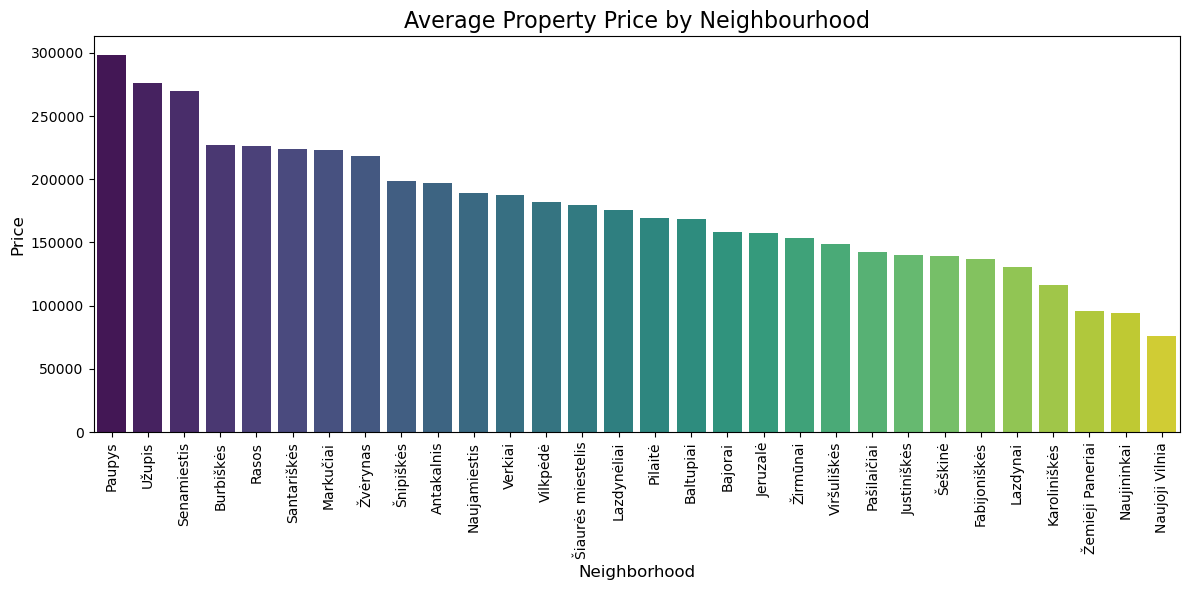

In [268]:


# Calculate the mean price for each neighborhood and sort by it
sorted_data = full_data.groupby('neighbourhood')['Price'].mean().sort_values(ascending=False).reset_index()

# Plot the bar chart with neighborhoods ordered by average price
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_data, x='neighbourhood', y='Price', palette='viridis', order=sorted_data['neighbourhood'])


plt.title('Average Property Price by Neighbourhood', fontsize=16)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()



### Minimum and Maximum Property Prices by Neighborhood'

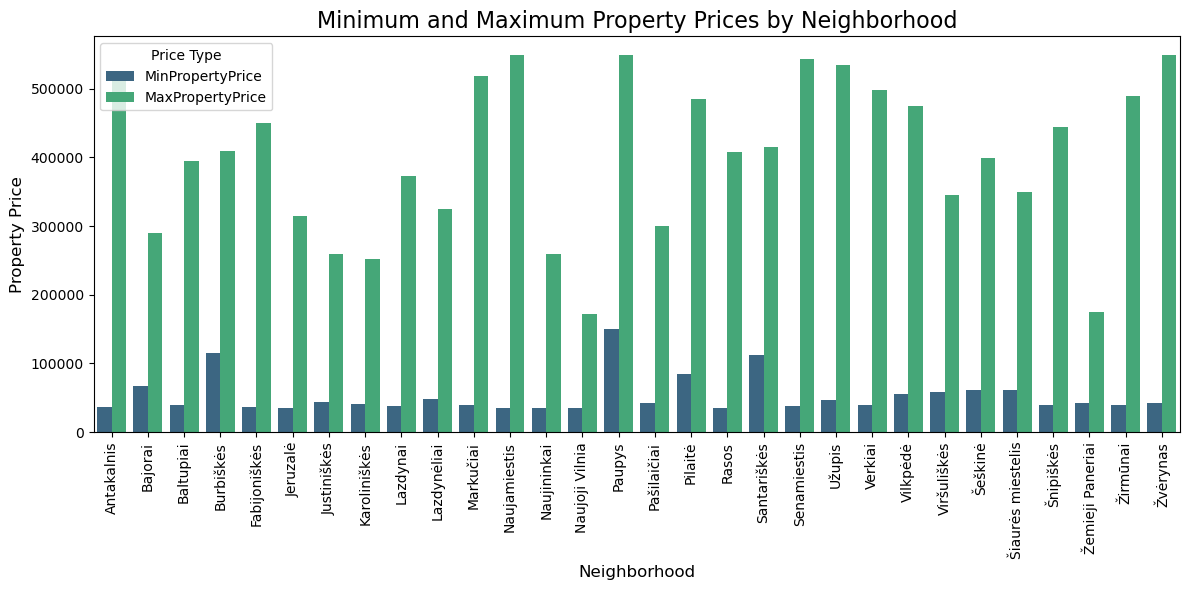

In [269]:


# Assuming 'full_data' is your DataFrame with columns 'neighbourhood' and 'Property Price'
# Group by neighborhood to calculate min and max property prices
grouped_data = full_data.groupby('neighbourhood')['Price'].agg(
    MinPropertyPrice='min',
    MaxPropertyPrice='max'
).reset_index()

# Melt the grouped data for plotting
df_melted = grouped_data.melt(
    id_vars='neighbourhood', 
    value_vars=['MinPropertyPrice', 'MaxPropertyPrice'], 
    var_name='Price Type', 
    value_name='Property Price'
)

# Create the grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_melted, 
    x='neighbourhood', 
    y='Property Price', 
    hue='Price Type', 
    palette='viridis'
)

# Customize the plot
plt.title('Minimum and Maximum Property Prices by Neighborhood', fontsize=16)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Property Price', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
plt.legend(title='Price Type', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Count of apartment listing by build year and building type

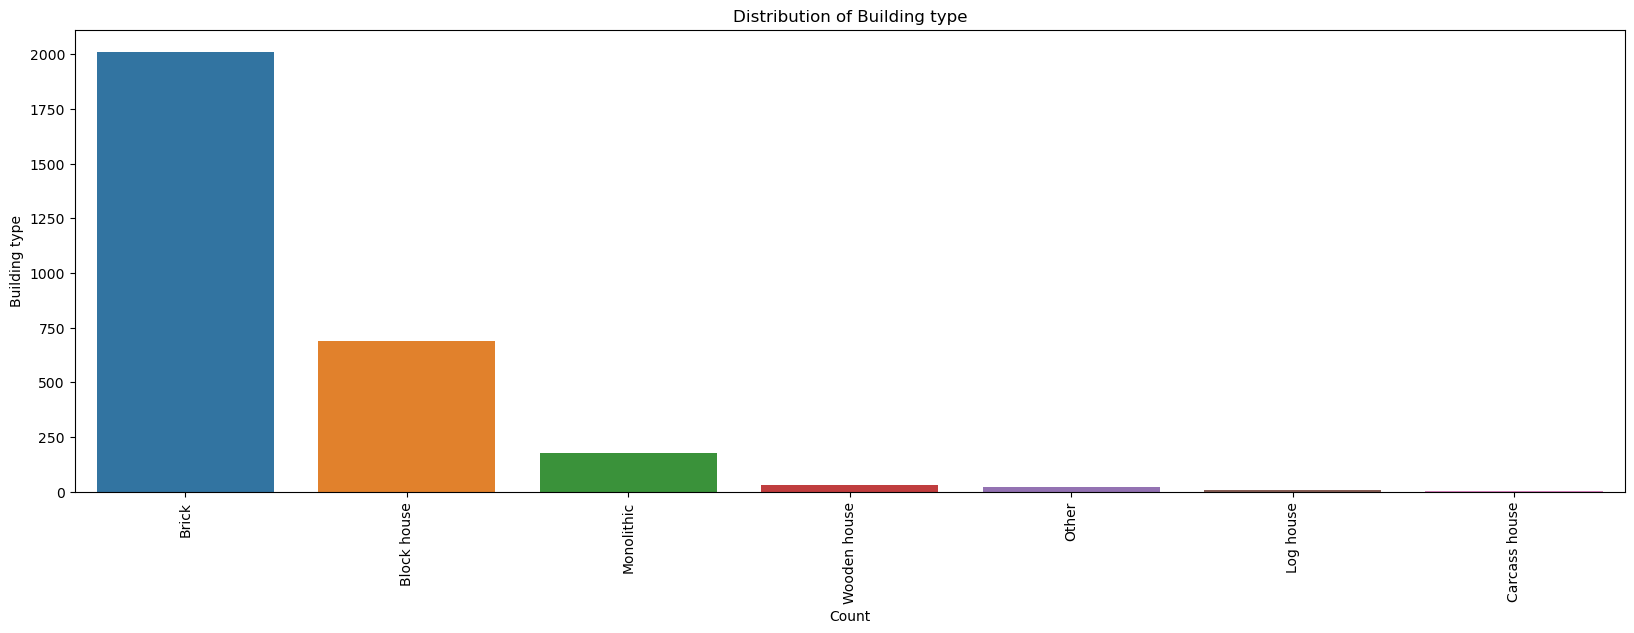

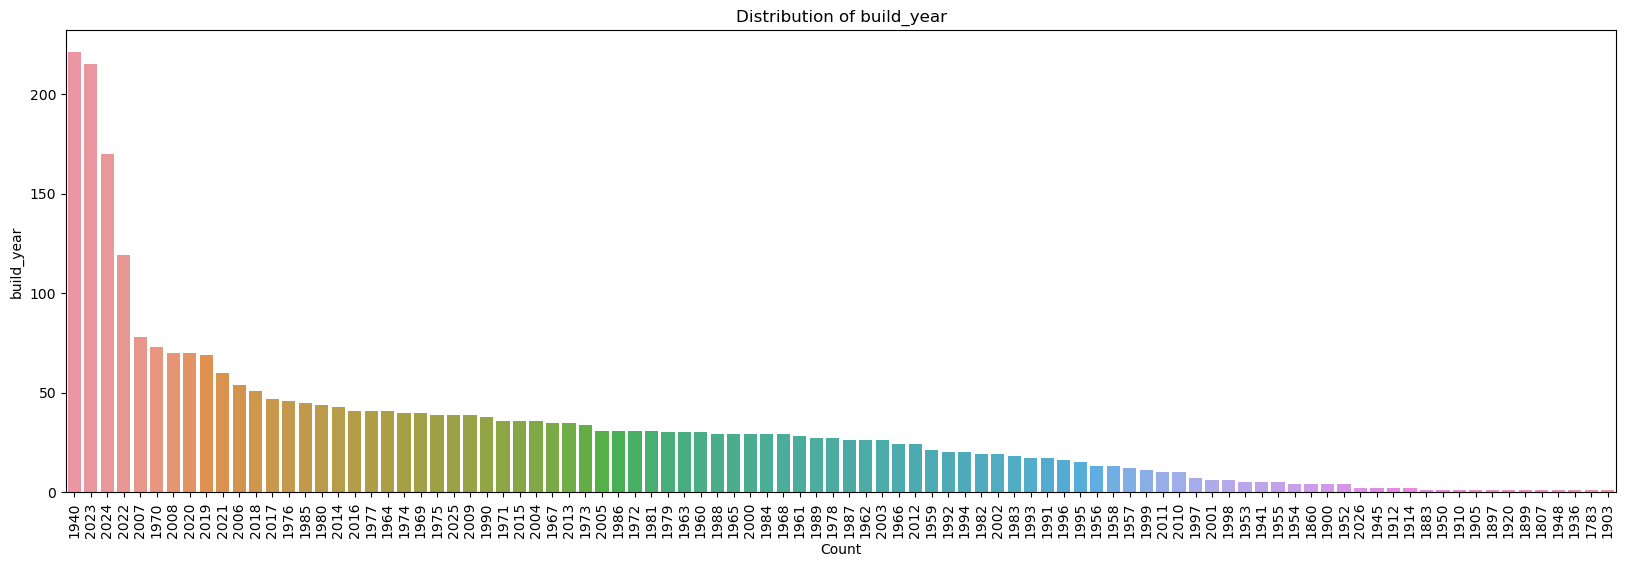

In [270]:
categorical_cols = [ 'Building type', 'build_year']
for col in categorical_cols:
    plt.figure(figsize=(20, 6))
    sns.countplot(x=col, data=full_data, order=full_data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.xticks(rotation=90)
    plt.show()


### Percentage of Building type in the scraped data

In [271]:
grouped_data = full_data.groupby(['neighbourhood', 'Building type']).size().unstack(fill_value=0).reset_index()
if 'Total' in grouped_data.index:
    grouped_data = grouped_data.drop('Total')


# Calculate total houses per neighborhood
grouped_data['Total'] = grouped_data.sum(axis=1)


grouped_data['Brick%'] = grouped_data['Brick'] /grouped_data['Total'] *100
grouped_data['Block%'] = grouped_data['Block house'] /grouped_data['Total'] *100

grouped_data['Carcass%'] = grouped_data['Carcass house'] / grouped_data['Total'] * 100
grouped_data['Log%'] = grouped_data['Log house'] / grouped_data['Total'] * 100
grouped_data['Monolithic%'] = grouped_data['Monolithic'] / grouped_data['Total'] * 100
grouped_data['Other%'] = grouped_data['Other'] / grouped_data['Total'] * 100
grouped_data['Wooden%'] = grouped_data['Wooden house'] / grouped_data['Total'] * 100

/var/folders/j6/6_wpjwxs4gn4nrcdtwrqvnbm0000gp/T/ipykernel_28592/2232001893.py:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [272]:
grouped_data

Building type,neighbourhood,Block house,Brick,Carcass house,Log house,Monolithic,Other,Wooden house,Total,Brick%,Block%,Carcass%,Log%,Monolithic%,Other%,Wooden%
0,Antakalnis,22,154,0,1,2,0,1,180,85.555556,12.222222,0.000000,0.555556,1.111111,0.000000,0.555556
1,Bajorai,4,32,0,0,4,0,0,40,80.000000,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000
2,Baltupiai,12,62,0,0,4,0,0,78,79.487179,15.384615,0.000000,0.000000,5.128205,0.000000,0.000000
3,Burbiškės,2,24,0,0,2,0,0,28,85.714286,7.142857,0.000000,0.000000,7.142857,0.000000,0.000000
4,Fabijoniškės,69,38,1,0,9,0,0,117,32.478632,58.974359,0.854701,0.000000,7.692308,0.000000,0.000000
5,Jeruzalė,1,43,0,0,0,0,0,44,97.727273,2.272727,0.000000,0.000000,0.000000,0.000000,0.000000
6,Justiniškės,41,48,0,0,4,1,0,94,51.063830,43.617021,0.000000,0.000000,4.255319,1.063830,0.000000
7,Karoliniškės,83,20,1,0,4,1,0,109,18.348624,76.146789,0.917431,0.000000,3.669725,0.917431,0.000000
8,Lazdynai,64,19,0,0,6,0,0,89,21.348315,71.910112,0.000000,0.000000,6.741573,0.000000,0.000000
9,Lazdynėliai,4,80,0,0,1,0,0,85,94.117647,4.705882,0.000000,0.000000,1.176471,0.000000,0.000000


### Building Type Distribution by Neighborhood

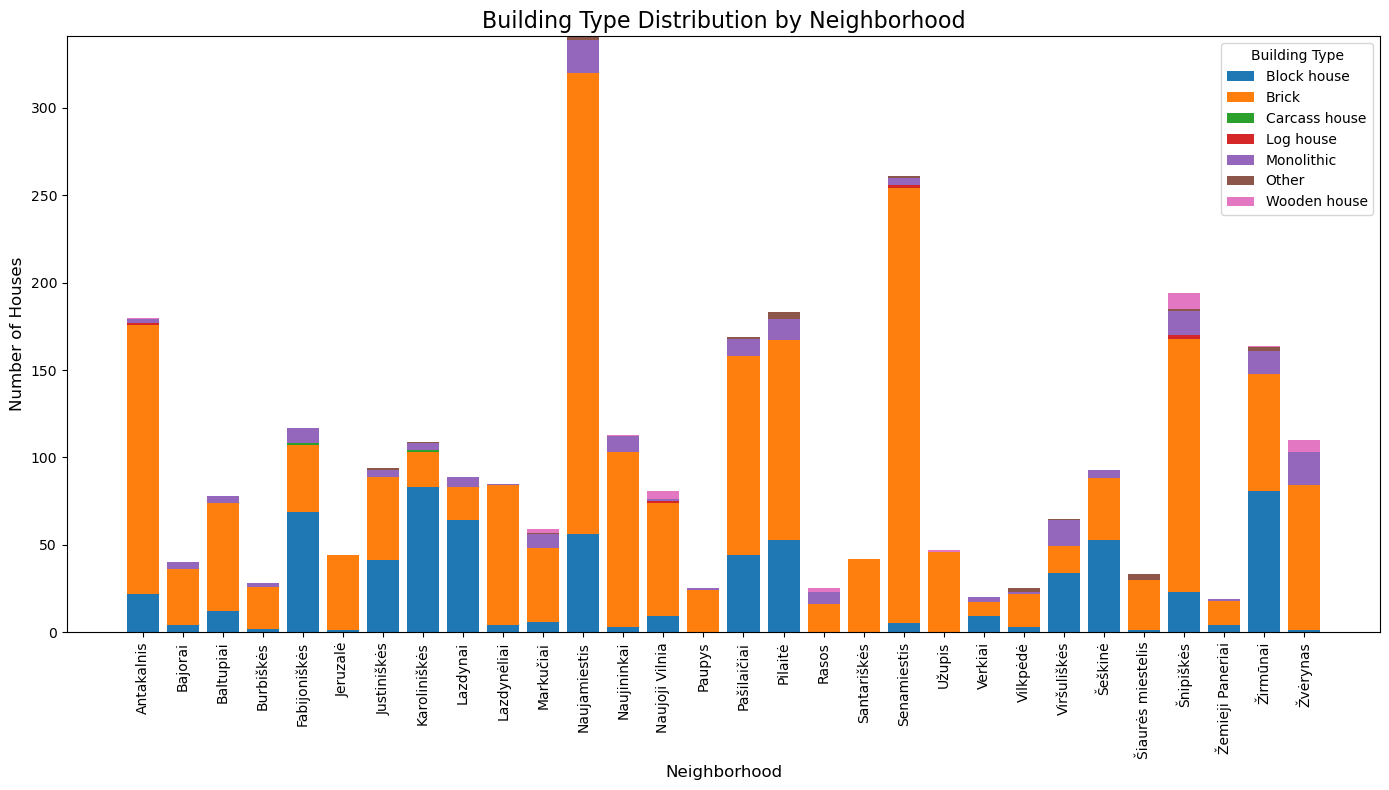

In [273]:


# Plot the stacked bar chart
plt.figure(figsize=(14, 8))

# Create the stacked bars
bottom = None
for column in ['Block house', 'Brick', 'Carcass house', 'Log house', 'Monolithic',
       'Other', 'Wooden house']:
    plt.bar(
        grouped_data['neighbourhood'], 
        grouped_data[column], 
        bottom=bottom, 
        label=column
    )
    if bottom is None:
        bottom = grouped_data[column]
    else:
        bottom += grouped_data[column]

# Customize the chart
plt.title('Building Type Distribution by Neighborhood', fontsize=16)
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Houses', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for readability
plt.legend(title='Building Type', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Price VS Demographics

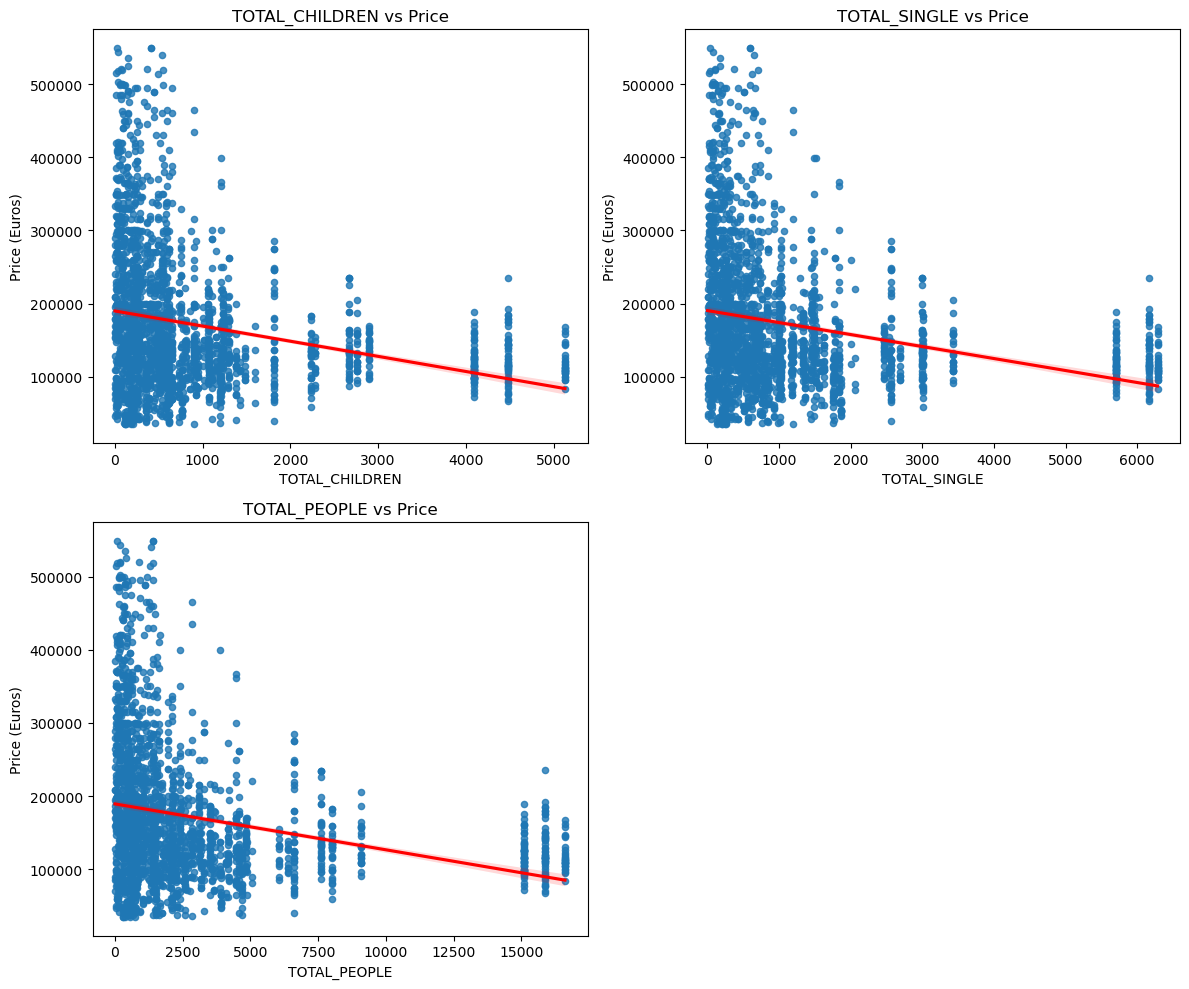

In [ ]:


# Create a 2x2 grid of scatter plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot 1: Public transport stop vs Price
sns.regplot(
    data=full_data, 
    x='TOTAL_CHILDREN', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[0, 0]
)
axs[0, 0].set_title('TOTAL_CHILDREN vs Price', fontsize=12)
axs[0, 0].set_xlabel('TOTAL_CHILDREN', fontsize=10)
axs[0, 0].set_ylabel('Price (Euros)', fontsize=10)

# Scatter plot 2: TOTAL_SINGLE vs Price
sns.regplot(
    data=full_data, 
    x='TOTAL_SINGLE', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[0, 1]
)
axs[0, 1].set_title('TOTAL_SINGLE vs Price', fontsize=12)
axs[0, 1].set_xlabel('TOTAL_SINGLE', fontsize=10)
axs[0, 1].set_ylabel('Price (Euros)', fontsize=10)

# Scatter plot 3: TOTAL_PEOPLE vs Price
sns.regplot(
    data=full_data, 
    x='TOTAL_PEOPLE', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[1, 0]
)
axs[1, 0].set_title('TOTAL_PEOPLE vs Price', fontsize=12)
axs[1, 0].set_xlabel('TOTAL_PEOPLE', fontsize=10)
axs[1, 0].set_ylabel('Price (Euros)', fontsize=10)

# Turn off the last subplot (bottom-right)
axs[1, 1].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


### Price vs Proximity to Amenities

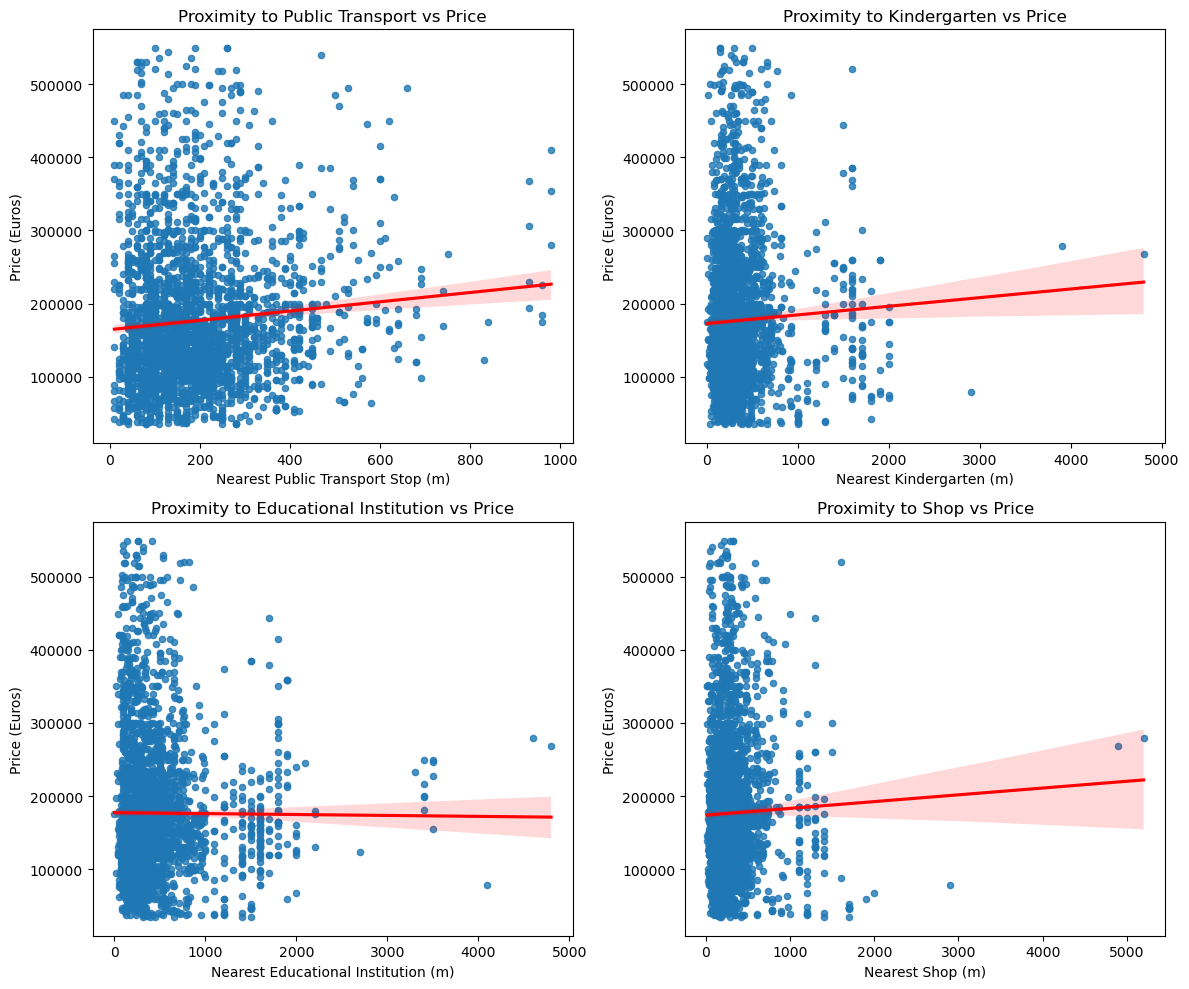

In [277]:



# Create a 2x2 grid of scatter plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot 1: Public transport stop vs Price
sns.regplot(
    data=full_data, 
    x='Public transport stop', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[0, 0]
)
axs[0, 0].set_title('Proximity to Public Transport vs Price', fontsize=12)
axs[0, 0].set_xlabel('Nearest Public Transport Stop (m)', fontsize=10)
axs[0, 0].set_ylabel('Price (Euros)', fontsize=10)

# Scatter plot 2: Nearest kindergarten vs Price
sns.regplot(
    data=full_data, 
    x='Nearest kindergarten', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[0, 1]
)
axs[0, 1].set_title('Proximity to Kindergarten vs Price', fontsize=12)
axs[0, 1].set_xlabel('Nearest Kindergarten (m)', fontsize=10)
axs[0, 1].set_ylabel('Price (Euros)', fontsize=10)

# Scatter plot 3: Nearest educational institution vs Price
sns.regplot(
    data=full_data, 
    x='Nearest educational institution', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[1, 0]
)
axs[1, 0].set_title('Proximity to Educational Institution vs Price', fontsize=12)
axs[1, 0].set_xlabel('Nearest Educational Institution (m)', fontsize=10)
axs[1, 0].set_ylabel('Price (Euros)', fontsize=10)

# Scatter plot 4: Nearest shop vs Price
sns.regplot(
    data=full_data, 
    x='Nearest shop', 
    y='Price', 
    scatter_kws={'s': 20}, 
    line_kws={'color': 'red'}, 
    ax=axs[1, 1]
)
axs[1, 1].set_title('Proximity to Shop vs Price', fontsize=12)
axs[1, 1].set_xlabel('Nearest Shop (m)', fontsize=10)
axs[1, 1].set_ylabel('Price (Euros)', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()

In [278]:
grouped_data

Building type,neighbourhood,Block house,Brick,Carcass house,Log house,Monolithic,Other,Wooden house,Total,Brick%,Block%,Carcass%,Log%,Monolithic%,Other%,Wooden%
0,Antakalnis,180,154,0,1,2,0,1,180,85.555556,12.222222,0.000000,0.555556,1.111111,0.000000,0.555556
1,Bajorai,40,32,0,0,4,0,0,40,80.000000,10.000000,0.000000,0.000000,10.000000,0.000000,0.000000
2,Baltupiai,78,62,0,0,4,0,0,78,79.487179,15.384615,0.000000,0.000000,5.128205,0.000000,0.000000
3,Burbiškės,28,24,0,0,2,0,0,28,85.714286,7.142857,0.000000,0.000000,7.142857,0.000000,0.000000
4,Fabijoniškės,117,38,1,0,9,0,0,117,32.478632,58.974359,0.854701,0.000000,7.692308,0.000000,0.000000
5,Jeruzalė,44,43,0,0,0,0,0,44,97.727273,2.272727,0.000000,0.000000,0.000000,0.000000,0.000000
6,Justiniškės,94,48,0,0,4,1,0,94,51.063830,43.617021,0.000000,0.000000,4.255319,1.063830,0.000000
7,Karoliniškės,109,20,1,0,4,1,0,109,18.348624,76.146789,0.917431,0.000000,3.669725,0.917431,0.000000
8,Lazdynai,89,19,0,0,6,0,0,89,21.348315,71.910112,0.000000,0.000000,6.741573,0.000000,0.000000
9,Lazdynėliai,85,80,0,0,1,0,0,85,94.117647,4.705882,0.000000,0.000000,1.176471,0.000000,0.000000


### Price vs Area

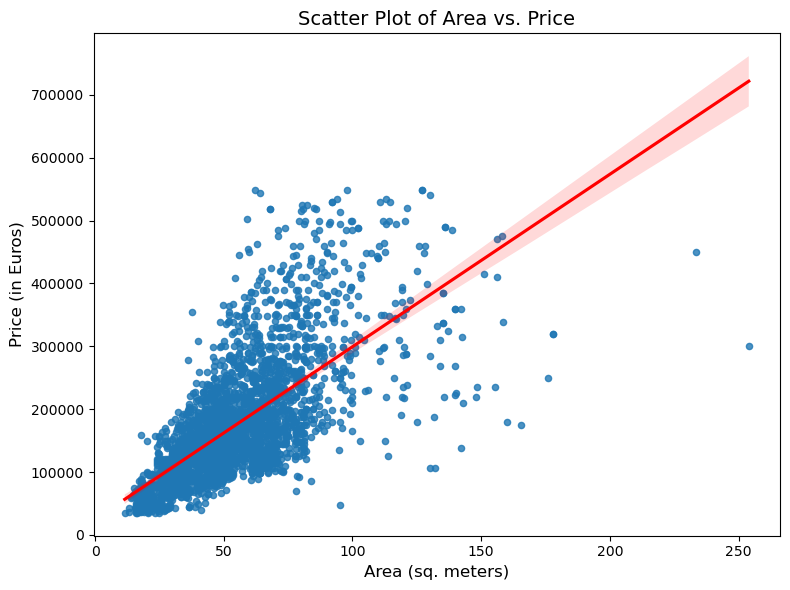

In [279]:
# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(data=full_data, x='Area', y='Price', scatter_kws={'s': 20}, line_kws={'color': 'red'})


# Add titles and labels
plt.title('Scatter Plot of Area vs. Price', fontsize=14)
plt.xlabel('Area (sq. meters)', fontsize=12)
plt.ylabel('Price (in Euros)', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

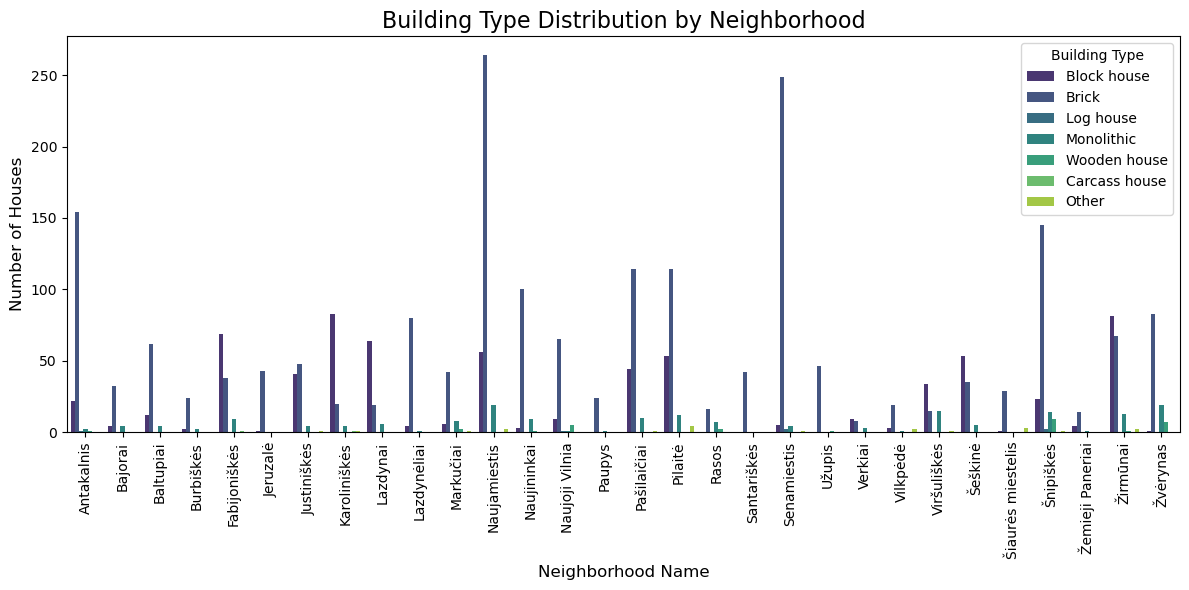

In [280]:
grouped_data = full_data.groupby(['neighbourhood', 'Building type']).size().reset_index(name='Number of Houses')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_data, 
    x='neighbourhood', 
    y='Number of Houses', 
    hue='Building type', 
    palette='viridis'
)

# Customize the plot
plt.title('Building Type Distribution by Neighborhood', fontsize=16)
plt.xlabel('Neighborhood Name', fontsize=12)
plt.ylabel('Number of Houses', fontsize=12)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better visibility
plt.legend(title='Building Type', fontsize=10)

# Adjust layout
plt.tight_layout()


In [281]:


# Assuming 'full_data' is your DataFrame and 'renovation_year' and 'build_year' are columns
full_data['renovation_year'] = full_data.apply(
    lambda row: row['build_year'] if pd.isnull(row['renovation_year']) else row['renovation_year'],
    axis=1
)


### Correlation of numerical variables to Price

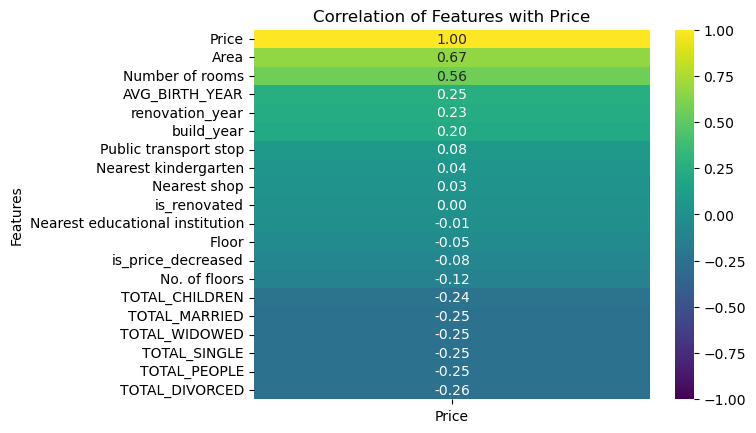

In [ ]:
plt.figure(figsize=(12, 6))
correlation_matrix = full_data.corr()
price_correlation = correlation_matrix[['Price']].sort_values(by='Price', ascending=False)

# Create a heatmap for 'Price' correlations
sns.heatmap(price_correlation, annot=True, cmap='viridis', fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title('Correlation of Features with Price')

plt.ylabel('Features')
plt.show()


## Population and Price

In [284]:
neighbourhood_summary = population.groupby(["neighbourhood"]).agg(
    AVG_BIRTH_YEAR=("BIRTH_YEAR", "mean"),              # Average birth year
    TOTAL_CHILDREN=("NUMBER_OF_CHILDREN", "sum"),       # Total children per street
    MARITAL_STATUS_COUNTS=("MARITAL_STATUS", lambda x: x.value_counts().to_dict()),  # Count of each marital status
    TOTAL_PEOPLE=("BIRTH_YEAR", "count")                # Total count of people per street
    
).reset_index()

In [285]:

# Calculate the average number of people per neighborhood
average_people = neighbourhood_summary['TOTAL_PEOPLE'].mean()

# Filter neighborhoods with more people than the average (Populated neighborhoods)
populated_neighbourhoods = neighbourhood_summary[neighbourhood_summary['TOTAL_PEOPLE'] > average_people].sort_values('TOTAL_PEOPLE', ascending=False)



# Calculate the average number of people per neighborhood
average_people = neighbourhood_summary['TOTAL_PEOPLE'].mean()\
# Print the total number of people in the populated neighborhoods
print('Total number of people in populated neighborhoods: ',
populated_neighbourhoods['TOTAL_PEOPLE'].sum())

Total number of people in populated neighborhoods:  429762


In [286]:


# Calculate the average number of people per neighborhood
average_people = neighbourhood_summary['TOTAL_PEOPLE'].mean()

# Filter neighborhoods with more people than the average (Populated neighborhoods)
populated_neighbourhoods = neighbourhood_summary[neighbourhood_summary['TOTAL_PEOPLE'] > average_people].sort_values('TOTAL_PEOPLE', ascending=False)

# Print the total number of people in the populated neighborhoods
print('Total number of people in populated neighborhoods: ',
populated_neighbourhoods['TOTAL_PEOPLE'].sum())



avg_price_per_neighborhood = full_data.groupby('neighbourhood').mean().reset_index()

# Merge to get average number of people and the number of people per neighborhood
populated_neighbourhoods_data = pd.merge(avg_price_per_neighborhood, populated_neighbourhoods, left_on='neighbourhood', right_on='neighbourhood')
populated_neighbourhoods_data_sorted = populated_neighbourhoods_data.sort_values('TOTAL_PEOPLE_y', ascending=False)[['neighbourhood', 'Price','TOTAL_PEOPLE_y']].rename(columns={'TOTAL_PEOPLE_y': 'Number of People', 'Price': 'Average Price'})


populated_neighbourhoods_data_sorted.shape



Total number of people in populated neighborhoods:  429762


/var/folders/j6/6_wpjwxs4gn4nrcdtwrqvnbm0000gp/T/ipykernel_28592/1949117959.py:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



(11, 3)

In [287]:



# Filter neighborhoods with more people than the average (Populated neighborhoods)
less_populated_neighbourhoods = neighbourhood_summary[neighbourhood_summary['TOTAL_PEOPLE'] < average_people].sort_values('TOTAL_PEOPLE', ascending=False)

# Print the total number of people in the populated neighborhoods
print('Total number of people in less populated neighborhoods: ',
less_populated_neighbourhoods['TOTAL_PEOPLE'].sum())



# Merge to get average number of people and the number of people per neighborhood
less_populated_neighbourhoods_data = pd.merge(avg_price_per_neighborhood, less_populated_neighbourhoods, left_on='neighbourhood', right_on='neighbourhood')
less_populated_neighbourhoods_data_sorted = less_populated_neighbourhoods_data.sort_values('TOTAL_PEOPLE_y', ascending=False)[['neighbourhood', 'Price','TOTAL_PEOPLE_y']].rename(columns={'TOTAL_PEOPLE_y': 'Number of People', 'Price': 'Average Price'})


less_populated_neighbourhoods_data_sorted



Total number of people in less populated neighborhoods:  175451


,neighbourhood,Average Price,Number of People
0,Justiniškės,139979.031915,26263
3,Senamiestis,269628.509579,25609
1,Karoliniškės,116695.412844,24643
4,Vilkpėdė,182254.480000,19608
6,Šnipiškės,198901.427835,17270
7,Žvėrynas,218574.781818,13903
5,Viršuliškės,148987.800000,13798
2,Rasos,226686.600000,12359


In [288]:
populated_neighbourhoods.neighbourhood.unique()

array(['Verkiai', 'Žirmūnai', 'Pašilaičiai', 'Antakalnis',
       'Naujoji Vilnia', 'Fabijoniškės', 'Naujininkai', 'Naujamiestis',
       'Lazdynai', 'Pilaitė', 'Šeškinė'], dtype=object)

In [289]:
# Separate the data into popular and unpopular  neighborhoods
popular = full_data.loc[full_data['neighbourhood'].isin(populated_neighbourhoods.neighbourhood.unique())]
unpopular = full_data.loc[~full_data['neighbourhood'].isin(populated_neighbourhoods.neighbourhood.unique())]

# Print average metrics for popular neighborhoods
print('Average apartment metrics in popular neighborhoods:')
print(popular.mean())

# Print average metrics for unpopular neighborhoods
print('\nAverage apartment metrics in unpopular neighborhoods:')
print(unpopular.mean())

# Calculate the differences between popular and unpopular neighborhoods
print('\nDifference between popular and unpopular neighborhoods:')
print(popular.mean() - unpopular.mean())


Average apartment metrics in popular neighborhoods:
Area                                   54.111819
Number of rooms                         2.289032
Floor                                   3.676774
No. of floors                           6.173548
Nearest kindergarten                  355.361290
Nearest educational institution       417.851613
Nearest shop                          319.490323
Public transport stop                 191.692506
Price                              155722.714194
build_year                           1991.070323
renovation_year                      1995.568387
is_renovated                            0.092258
is_price_decreased                      0.269032
AVG_BIRTH_YEAR                       1981.991552
TOTAL_CHILDREN                        982.773651
TOTAL_PEOPLE                         3108.119131
TOTAL_DIVORCED                        368.348984
TOTAL_WIDOWED                         246.561317
TOTAL_MARRIED                        1212.417659
TOTAL_SINGLE     

/var/folders/j6/6_wpjwxs4gn4nrcdtwrqvnbm0000gp/T/ipykernel_28592/3169068509.py:7: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/j6/6_wpjwxs4gn4nrcdtwrqvnbm0000gp/T/ipykernel_28592/3169068509.py:11: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/j6/6_wpjwxs4gn4nrcdtwrqvnbm0000gp/T/ipykernel_28592/3169068509.py:15: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select 